# Comparing Boston and Seattle airbnb prices: 

## What features affect the prices the most?

In [1]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Gathering data
s_calendar = pd.read_csv('calendar_seattle.csv')
s_listings = pd.read_csv('listings_seattle.csv')
#s_reviews = pd.read_csv('reviews_seattle.csv')
b_calendar = pd.read_csv('calendar_boston.csv')
b_listings = pd.read_csv('listings_boston.csv')
#b_reviews = pd.read_csv('reviews_boston.csv')


Assess: have a look at the data

In [255]:
s_listings.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,...,10.0,f,NaN,WASHINGTON,f,strict,f,f,2,1.15
3,7421966,https://www.airbnb.com/rooms/7421966,20160104002432,2016-01-04,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,none,NaN,...,NaN,f,NaN,WASHINGTON,f,flexible,f,f,1,NaN
4,278830,https://www.airbnb.com/rooms/278830,20160104002432,2016-01-04,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,none,We are in the beautiful neighborhood of Queen ...,...,9.0,f,NaN,WASHINGTON,f,strict,f,f,1,0.89


In [256]:
s_calendar.head()

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


In [7]:
# Some utiity function
def fix_price(x):
    """
    Convert price in string format with $ sign to a float
    input: a string including a price with optional $ symbol
    output: a float
    """
    if type(x)==str:
        x=x.replace('$','')
        x=x.replace(',','')
        x=float(x)
    return x

In [371]:
# We start with selecting all Numerical features
df = s_listings.select_dtypes(include=['int64','float64']).copy()

In [372]:
# Cleaning the data
# we remove some features we believe are non relevant
df.drop(['host_id','scrape_id','latitude','longitude',
            'minimum_nights','maximum_nights','availability_30','availability_60','availability_90',
            'availability_365','calculated_host_listings_count'],axis=1, inplace=True)
# This ones are removed as column is almost empty
df.drop(['square_feet','license'], axis=1, inplace=True)
#We keep  the review_scores_ratings among all review scores
df.drop(['review_scores_accuracy','review_scores_checkin','review_scores_cleanliness',
            'review_scores_checkin','review_scores_communication','review_scores_location','review_scores_value',
            'reviews_per_month'], axis=1, inplace=True)
df.shape

(3818, 10)

In [373]:
# converting the price from string with $ to float
df['price'] = s_listings['price'].apply(fix_price)

In [374]:
# Binary Categorical Columns with T/F values
for tf_feature in ['host_is_superhost', 'host_identity_verified', 'host_has_profile_pic',
                   'is_location_exact', 'requires_license', 'instant_bookable',
                   'require_guest_profile_picture', 'require_guest_phone_verification']:
    df[tf_feature] = s_listings[tf_feature].map(lambda s: False if s == "f" else True)
    
df.shape

(3818, 19)

In [375]:
# One-hot encoding of categorical fetures
for categorical_feature in ['neighbourhood_cleansed', 'property_type', 'room_type', 'bed_type']:
    df = pd.concat([df, pd.get_dummies(s_listings[categorical_feature])], axis=1)
df.shape

(3818, 130)

In [376]:
# The column amenities requires some preprocessing
s_listings['amenities'].head()

0    {TV,"Cable TV",Internet,"Wireless Internet","A...
1    {TV,Internet,"Wireless Internet",Kitchen,"Free...
2    {TV,"Cable TV",Internet,"Wireless Internet","A...
3    {Internet,"Wireless Internet",Kitchen,"Indoor ...
4    {TV,"Cable TV",Internet,"Wireless Internet",Ki...
Name: amenities, dtype: object

In [377]:
s_listings.amenities = s_listings.amenities.str.replace("[{}\"]", "")
#s_listings.amenities = s_listings.amenities.str.replace("\"", "")
df = pd.concat([df, s_listings.amenities.str.get_dummies(sep = ",")], axis=1)
df.shape

(3818, 171)

In [378]:
# Handling null values
# We need to impute values in columns with nulls
columns_to_impute = list(df.isnull().sum().where(lambda x: x>0).dropna().index)
df.isnull().sum().where(lambda x: x>0).dropna()

host_listings_count            2.0
host_total_listings_count      2.0
bathrooms                     16.0
bedrooms                       6.0
beds                           1.0
review_scores_rating         647.0
dtype: float64

### So looking at the columns with null values we have:

host_listings_count and host_total_listings_count have only 2 missing values. The values in these two columns are 
numerical with values ranging from 1 to 502.

- _bathrooms_ has 16 missing values and they range from 1.0 to 8.0. The values are not integer as there are also 1.5, 2.5 etc

- _bedrooms_ has 6 missing values with values ranging from 1 to 7 (integer)

- _bed_ has 1 missing value with values ranging from 1 to 15 (integer)

- review_scores_rating has 647 missing value with values ranging from 1 to 100

So we will proceed as follows:
- review_scores_rating: we will impute using linear regression and round the value to the nearest 0.5
- host_listings_count and host_total_listings_count: as there are only 2 misisng values I am not worrried about introducing bias in the model so I will use the median 
- bed and bedrooms: I will impute using KNN
- bathrooms: I cannot use knn as the values are not integer, so KNN would fail and Linear Regression will generate a float that does not make sense. So I will use Linear Regression and round the result to 0.5



In [3]:
# We will use  linear regression to impute missing values
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression
 
def impute_nulls(df_imp, med_columns, knn_columns, lr_columns): 
    """
    Impute missing values in the dataset using KNN for the columns in the knn_columns list
    and Linear Regression for the columns in the lr_columns list. The values for lr_columns are 
    rounded to 0.5. Values in med_columns are imputed using the median
    
    input: dataframe, list of columns to apply KNN to, list if columns to apply Linear Regression to
    output: dataframe with imputed values
    """
    for col in med_columns:
        df_imp[col] = df_imp[col].fillna(df_imp[col].median())

    columns_to_impute = np.append(knn_columns,lr_columns) 
    # The train dataset will include all rows without nulls and without the columns to predict
    X_train= df_imp.dropna()

    # The test dataset will include onlt the dropped rows, where we want to predict
    for predictor in knn_columns:
        knn = KNeighborsClassifier()
        y_train = X_train[predictor]
        knn.fit(X_train.drop(columns_to_impute, axis=1), y_train)
        # Rows with null values in the predictor column
        X_test = df_imp.loc[df_imp.isna()[predictor], :].drop(columns_to_impute, axis=1)
        pred = knn.predict(X_test)
        df_imp.loc[df_imp.isna()[predictor], predictor] = pred
    
    for predictor in lr_columns:
        lmodel = LinearRegression()
        y_train = X_train[predictor]
        lmodel.fit(X_train.drop(columns_to_impute,axis=1), y_train)
        # Rows with null values in the predictor column
        X_test = df_imp.loc[df_imp.isna()[predictor], :].drop(columns_to_impute, axis=1)    
        pred = lmodel.predict(X_test)
        df_imp.loc[df_imp.isna()[predictor], predictor] = np.round(pred*2)/2
    
    return df_imp

In [9]:
knn_columns = ['beds','bedrooms']
lr_columns = ['review_scores_rating', 'bathrooms']
med_columns = ['host_listings_count','host_total_listings_count']

In [380]:
# Imputing finally
df=pd.concat([df.id, impute_nulls(df.drop('id',axis=1), med_columns, knn_columns, lr_columns)], axis=1)


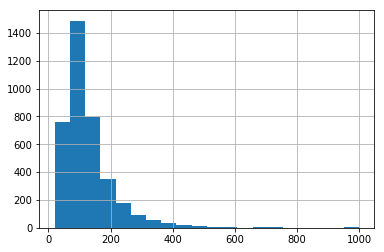

In [381]:
# Analyzing: Outliers
# Outliers need to be handled as they can affect linear regression badly
df['price'].hist(bins=20)

Looking at the distribution of the prices, it looks like prices over 600 usd per day are outliers and we can remove those datapoints, as outliers usually affect linear regression badly.

In [382]:
# Removing outliers in price column as they may affect linear regression
# 600 seems like a reasonable upper bound

df = df[df['price'] <=600]

In [4]:
# Putting all together in a function
def listings_preprocessing(listings):
    """
    Preprocessing on the listings dataset for linear regression:
        Selecting relevant nymerical features
        One hot encoding of categorical variables (including amenities)
        Removing columns with most null values
        Converting price column to float
        Encoding of binary variables 't,f'
        Imputing missing values in numerical columns with median
    input:  a dataframe of the airbnb listings
    output: a dataframe with preprocessed numerical features and one-hot-encoded categorical features;
            null values have been imputer
        
    """
    # Extracting numerical features
    df = listings.select_dtypes(include=['int64','float64']).copy()
    # Dropping non-relevant ones (at least the ones I believe not to be)
    df.drop(['host_id','scrape_id','latitude','longitude',
            'minimum_nights','maximum_nights','availability_30','availability_60','availability_90',
            'availability_365','calculated_host_listings_count'],axis=1, inplace=True)
    # This ones are removed as column is almost empty
    df.drop(['square_feet','license'], axis=1, inplace=True)
    #We keep  the review_scores_ratings among all review scores
    df.drop(['review_scores_accuracy','review_scores_checkin','review_scores_cleanliness',
            'review_scores_checkin','review_scores_communication','review_scores_location','review_scores_value',
            'reviews_per_month'], axis=1, inplace=True)
    
    # converting the price from string with $ to float
    df['price'] = listings['price'].apply(fix_price)
    
    # Binary Categorical Columns with T/F values
    for tf_feature in ['host_is_superhost', 'host_identity_verified', 'host_has_profile_pic',
                   'is_location_exact', 'requires_license', 'instant_bookable',
                   'require_guest_profile_picture', 'require_guest_phone_verification']:
        df[tf_feature] = listings[tf_feature].map(lambda s: False if s == "f" else True)
    
    # One-hot encoding of categorical fetures
    for categorical_feature in ['neighbourhood_cleansed', 'property_type', 'room_type', 'bed_type']:
        df = pd.concat([df, pd.get_dummies(listings[categorical_feature])], axis=1)
    # Amenities column
    listings.amenities = listings.amenities.str.replace("[{}\"]", "")
    df = pd.concat([df, listings.amenities.str.get_dummies(sep = ",")], axis=1)
    print(df.shape)
    
    # Imputing null values
    df=pd.concat([df.id, impute_nulls(df.drop('id',axis=1), med_columns, knn_columns, lr_columns)], axis=1)
    
    #Removing outliers in price column as they may affect linear regression
    df = df[df['price'] <=600]
        
    return df
    

## Which features affect the price the most?
We want to find which features affect the price the most. We will use a linear regression model and analyze the coefficients. We are not expecting the model to perform great in terms of minimizing the loss in the predictions as we are applying a very basic model without much optimizations (all default parameters), but we are mostly interested in how the predictors affect the final price, which ones are most important in driving the prices up and which ones bring a discount from the base price. Also we will fit the model to the whole dataset, as we are not looking at optimizing loss on a cross validated test vset.

In [5]:
# Finally, time to get down to business: Model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

def lr_model(df_listings):
    """
    Instantiate and fit linear regression model. Predict prices on the whole dataset
    Predict prices and compute (squared root of ) mean squared error and r2 score.
    input: a preprocessed dataframe of airbnb listings
    output: a fitted linear regression model, with rmse and r2 scores obtained after predicting the price with the model
    """
    model = LinearRegression()
    y = df_listings['price']
    X = df_listings.drop('price', axis=1)
    model.fit(X, y)
    y_pred = model.predict(X)
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    r2 = r2_score(y, y_pred)
    return model, rmse, r2

In [10]:
# Fitting the model on Seattle dataset, computing predictions, mean squared error and r2 score

df_seattle = listings_preprocessing(s_listings)
s_model, s_rmse, s_r2 = lr_model(df_seattle)
print("Seattle mean squared error (square root): ",s_rmse)
print("seattle r2 score: ",s_r2)

(3818, 171)
Seattle mean squared error (square root):  47.13233219010629
seattle r2 score:  0.6536377652811419


This indicates that usually our model misses the right price by something around 34 usd.
R-squared is a statistical measure of how close the data are to the fitted regression line.
R-squared is always between 0 and 100%:

0% indicates that the model explains none of the variability of the response data around its mean.
100% indicates that the model explains all the variability of the response data around its mean.
Our result therefore says that predictors can explain around 65% of the variability.
So that's not really great, but expected considering the simplicity of the model.

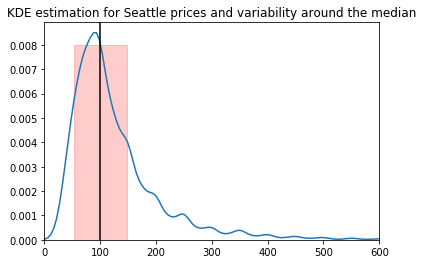

In [11]:
# Visualizing : Showing  prices variabilkity around the median
import matplotlib.patches as patches

y = df_seattle.price
ax = sns.kdeplot(y, legend=False)
ax.set_xlim([0, 600])
plt.axvline(y.median(), c='black')
ax.add_patch(patches.Rectangle((y.median() - s_rmse, 0), 2*s_rmse, 0.008,
                      color='r', alpha=0.2)
)
plt.title('KDE estimation for Seattle prices and variability around the median');

In [12]:
# Visuaizing coefficients
#So that's not really great, but expected considering the simplicity of the model
#Let's have a look at the coeficients of the linear regression to understand which features are most relevant
def takefirst(elem):
    """
    Extract abs of coefficient from model coefficient list
    input: a list
    output: the abs value of the first element
    """
    return abs(elem[0])

lr_coefficients = list(zip(s_model.coef_, df_seattle.drop('price', axis=1)))
lr_coefficients.sort(key=takefirst, reverse=True)
lr_coefficients

[(-131.78399267056218, 'Dorm'),
 (68.18172971781685, 'Pioneer Square'),
 (61.560583057846664, 'Industrial District'),
 (-57.78250347860607, 'South Park'),
 (-56.306883968359905, 'host_has_profile_pic'),
 (56.01181882922871, 'Treehouse'),
 (49.85674485180111, 'Pike-Market'),
 (47.93536584950277, 'Loft'),
 (44.54430595795679, 'Southeast Magnolia'),
 (43.81209581509722, 'Chalet'),
 (42.360817766540904, 'Camper/RV'),
 (42.10444045081868, 'Bed & Breakfast'),
 (40.808933923312004, 'Sunset Hill'),
 (39.747675456709324, 'Cabin'),
 (38.91770365914148, 'Boat'),
 (-38.002568028981216, 'Crown Hill'),
 (37.83717081238164, 'Portage Bay'),
 (37.543752113213856, 'Entire home/apt'),
 (-37.078037585265065, 'Shared room'),
 (36.63804230377956, 'Bungalow'),
 (35.88153873866369, 'West Queen Anne'),
 (35.80831374953406, 'Westlake'),
 (-35.68940551014276, 'Haller Lake'),
 (34.89128358119032, 'Holly Park'),
 (32.70362435881365, 'South Lake Union'),
 (32.1684763111388, 'Doorman'),
 (-31.393848713403372, 'Mid-B

### So what predictors affect the price the most?
Answer:

Analysis: it seems that neighborhoods are quite important in affecting prices (as expected), looking the difference between trendy suburbs (+68 usd) and bad ones (-67 usd)

Staying in a dorm or sharing a room gives good savings, while choosing a loft comes at a premium. 
Additional bedrooms and bathrooms will cost you 31 usd and 22 usd respectevely, not as much as expected, but understandable considering these are not hotel rooms but privately rented apartments.

Seaview is surpisingly negative (-14$) so people in the west coast don't fancy a seaview? But... wait a minute, that doesn't refer to that an apartment "with" seaview  but to an apartment "in" Seaview (a neighborhood in Seattle, and apparently not a great one https://www.trulia.com/real_estate/Seaview-Seattle/6872/crime/).


The review_scores_rating is almost neutral (0.51) and so is number of reviews (-0,20) 

So since it seems that neighborhoods are what matter most (that's reat estate for you), let's have a look at them with a plot.

Text(0.5,1,'Seattle Neighborhoods Average Pricing')

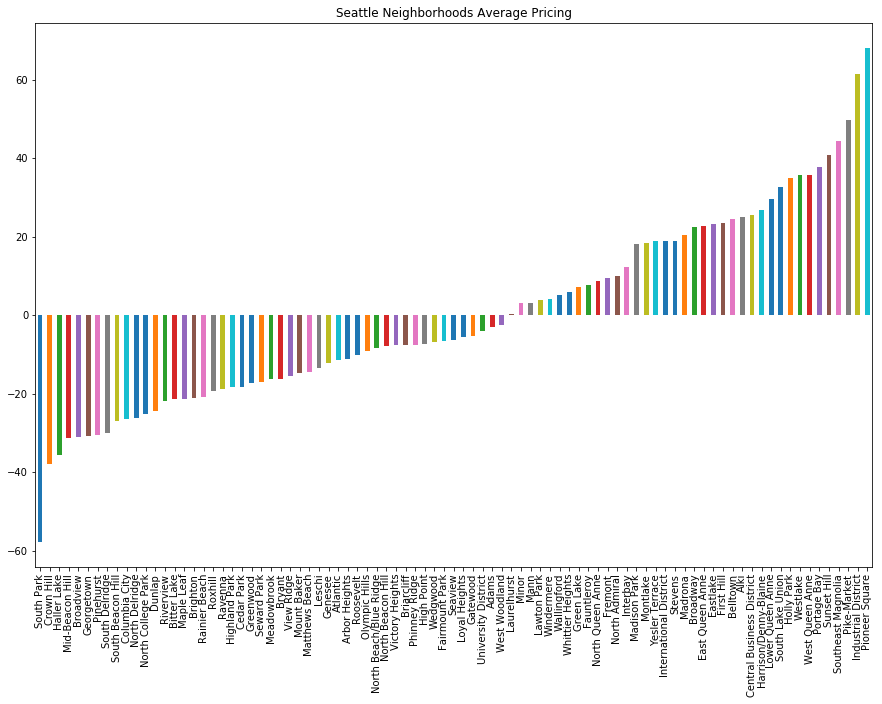

In [13]:
# We can dig into the neighborhoods: visualizing how neighborhoods affect price
neighborhoods = np.unique(s_listings['neighbourhood_cleansed'])
n_coeff = [c for c in lr_coefficients if c[1] in neighborhoods]
n_coeff
n_s=pd.Series(data=[n[0] for n in n_coeff], index=[n[1] for n in n_coeff]).sort_values()

#Plot
n_s.plot(kind='bar',figsize=(15,10), )
plt.title('Seattle Neighborhoods Average Pricing')

Good neighborhoods can come at a premium of 60+ usd, although the majority of them are under the 40 usd threshold. Similarly, most bad (or simply far from the trendy areas) neighborhoods bring a discount in the 0 to 40 usd range, with the exception of the infamous South Park.

### Are there other features affecting the price? What about the amenities offered, like TV, Wi-fi, etc.

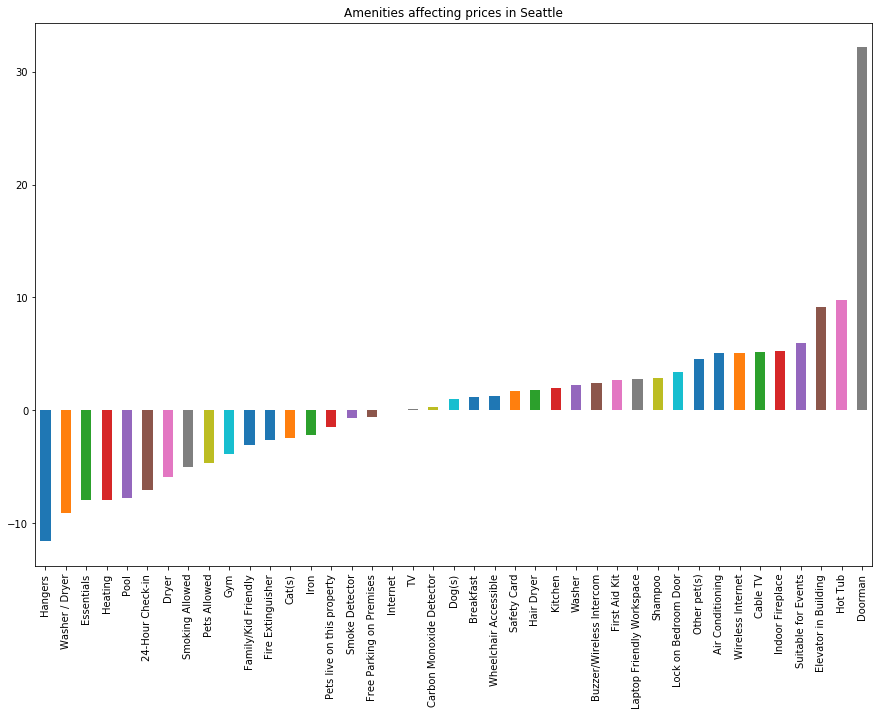

In [14]:
# The same can be plotted for the amenities offered
#amenities = np.unique(np.concatenate(listings['amenities'].map(lambda amns: amns.split("|"))))[1:]
amenities = np.unique(np.concatenate(s_listings['amenities'].str.replace("[{}\"]", "").map(lambda a : a.split(','))))[1:]
a_coeff = [c for c in lr_coefficients if c[1] in amenities]
a_s = pd.Series(data=[n[0] for n in a_coeff], index=[n[1] for n in a_coeff]).sort_values()
a_s.plot(kind='bar', figsize=(15,10))
plt.title('Amenities affecting prices in Seattle');

The plot aboves shows how amenities influence prices in Seattle. It seems a doorman is highly appreciated, but it will cost you more than 30 usd on abverage. Other amenities cause a variation of proce in the range of 0 to 10usd. We will see if we get something more interesting in Boston

In [15]:
#Let's have a look at Boston
# we drop 3 columns that are not in the Seattle dataset
df_boston = listings_preprocessing(b_listings.drop(['has_availability', 'jurisdiction_names', 'neighbourhood_group_cleansed'],
                                                   axis=1))
b_model, b_rmse, b_r2 = lr_model(df_boston)
print("Boston mean squared error (square root): ",b_rmse)
print("Boston r2 score: ",b_r2)

(3585, 110)
Boston mean squared error (square root):  59.14449339414119
Boston r2 score:  0.6582036258813322


The mean squared error is Boston is a bit larger that Seattle (43 usd vs 34) but this does not come as a surprise considering that Boston mean price is also bigger (201 vs 137 usd).

In [16]:
blr_coefficients = list(zip(b_model.coef_, df_boston.drop('price', axis=1).columns))
blr_coefficients.sort(key=takefirst, reverse=True)
blr_coefficients

[(-118.79319270659082, 'Camper/RV'),
 (75.58750977160702, 'Bay Village'),
 (60.91968208160367, 'Other'),
 (-56.63639647092924, 'Roslindale'),
 (51.750317205297385, 'Back Bay'),
 (-50.74898246455001, 'Hyde Park'),
 (49.926910220003094, 'Leather District'),
 (48.36478951371383, 'require_guest_phone_verification'),
 (-45.28740954605382, 'West Roxbury'),
 (-43.61869456161875, 'Mattapan'),
 (43.20485497960066, 'Downtown'),
 (-42.30361342475105, 'Dorm'),
 (42.239937867288596, 'South Boston Waterfront'),
 (-42.13026418981115, 'Dorchester'),
 (-41.63278569029859, 'Washer / Dryer'),
 (41.30931811728512, 'Beacon Hill'),
 (39.71882733244726, 'Boat'),
 (38.052277060636484, 'Entire home/apt'),
 (-37.844603249075796, 'Entire Floor'),
 (35.154329019222146, 'bedrooms'),
 (-33.637175826233005, 'require_guest_profile_picture'),
 (-32.66479905357928, 'Other pet(s)'),
 (-27.081829516006145, 'Jamaica Plain'),
 (-26.57264562165608, 'Mission Hill'),
 (-26.22844338896258, 'Brighton'),
 (25.95198657039481, 'So

Text(0.5,1,'Boston Neighborhoods Average Pricing')

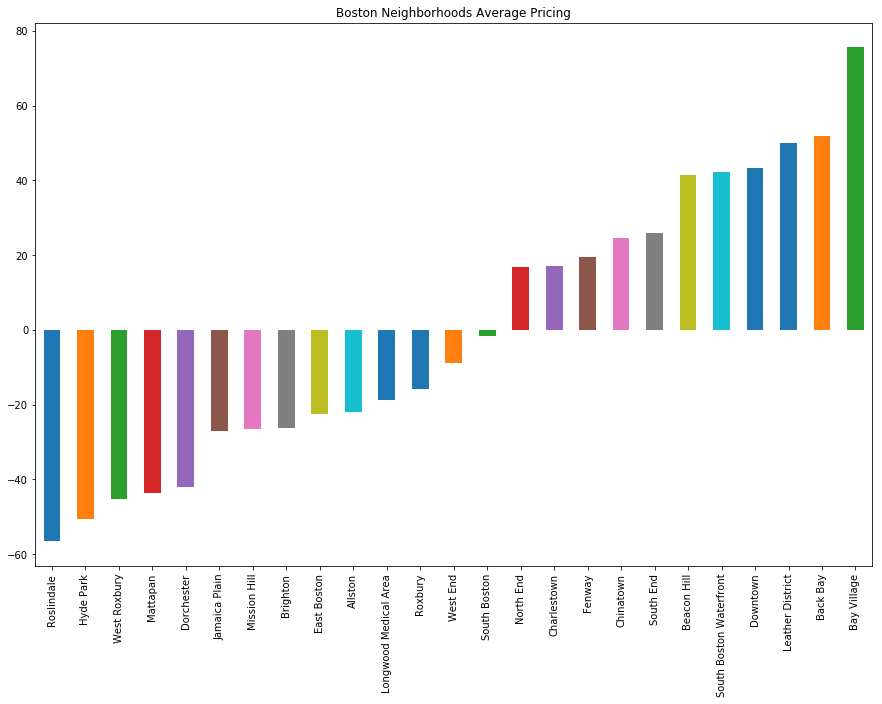

In [17]:
#We can have a look at Boston neighborhoods, too
# We can dig into the neighborhoods
b_neighborhoods = np.unique(b_listings['neighbourhood_cleansed'])
n_coeff = [c for c in blr_coefficients if c[1] in b_neighborhoods]
n_coeff
n_s=pd.Series(data=[n[0] for n in n_coeff], index=[n[1] for n in n_coeff]).sort_values()

#Plot
n_s.plot(kind='bar',figsize=(15,10))
plt.title('Boston Neighborhoods Average Pricing')

As for Seattle, in Boston too sought after areas come at a premium (here up to 87 usd) while the discount coming from stay away from the centre or good areas is not as beneficial as it was in Seattle. 

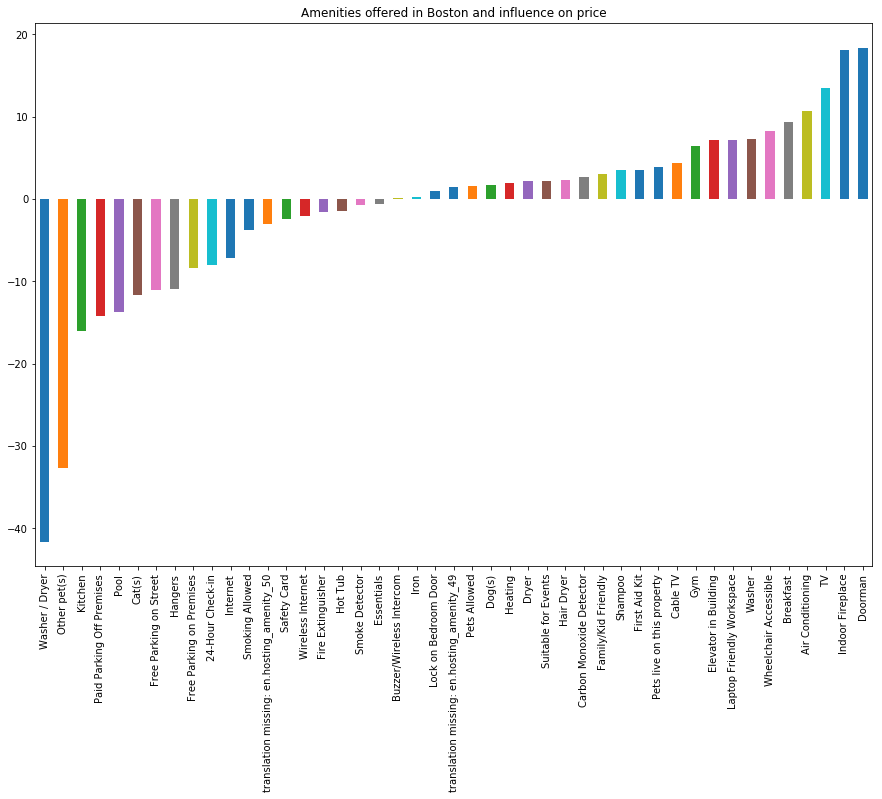

In [18]:
# Amenities in Boston
amenities = np.unique(np.concatenate(b_listings['amenities'].str.replace("[{}\"]", "").map(lambda a : a.split(','))))[1:]
a_coeff = [c for c in blr_coefficients if c[1] in amenities]
a_s = pd.Series(data=[n[0] for n in a_coeff], index=[n[1] for n in a_coeff]).sort_values()
a_s.plot(kind='bar', figsize=(15,10))
plt.title('Amenities offered in Boston and influence on price');

The data here looks a bit more interesting than Seattle, the influence on price looks a bit higher, in the range of 0 to 20 dollars with the exception of doorman and Indoor fireplace, while availability to allow pets in the apartment seems to bring a discount maybe because it can put some clients off.